# Secondary analyses

This notebook processes some of the secondary calculations reported in the text, but not used in the plots.

In [1]:
%pylab inline
import json
import numpy as np
import pandas as pd
import glob
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
output_dir = "../results-anonymized/experiment/"
files = glob.glob(output_dir+'block_*.json')

blocks = []
for file in files:
    with open(file) as f:
        blocks.append(json.load(f))

len(blocks)

30

In [3]:
# go through the raw data and pull out:
# - info on the number of rejections and adoptions each player makes
# - the timestamps of each drop event (player decision)
# - info on players' confidence in their decisions
# - the number of drop events in each game

collector = []
drops = []
times = []
for block in blocks:
    drops += [len([i for i in block[list(block.keys())[j]]['log'] if i['name'] == 'drop']) for j in [0,1]]
    for j in [0, 1]:
        startedAt = datetime.strptime(block[list(block.keys())[j]]['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ')
        times += [(datetime.strptime(i['createdAt'], '%Y-%m-%dT%H:%M:%S.%fZ') - startedAt).seconds
                      for i in block[list(block.keys())[j]]['log'] if i['name'] == 'drop']

    for game_id in block.keys():
        for player_id, player in block[game_id]['players'].items():
            info = dict()
            info['treatment'] = player['data.position'][0]
            info['caveman'] = "caveman" in game_id
            info['idled'] = len(player['data.log'])>0
            info['adoptions'] = len(player['data.notebooks']['promising_leads']['clueIDs'])
            info['rejections'] = len(player['data.notebooks']['dead_ends']['clueIDs'])
            
            
            info['completed'] = "data.caseMade" in player
            if "data.caseMade" in player:
                info['confidence'] = float(player['data.caseMade']['confidence'])
                info['max_assessment'] = np.max([float(v) for k, v in player['data.caseMade'].items() if k not in ["confidence", "consensus"]])
                info['min_assessment'] = np.min([float(v) for k, v in player['data.caseMade'].items() if k not in ["confidence", "consensus"]])
                info.update(player['data.caseMade'])
            else:
                info['confidence'] = 0
                info['max_assessment'] = 50
                info['min_assessment'] = 50
                
            if 'data.survey' in player:
                info.update(player['data.survey'])
            collector.append(info)
            
    
df = pd.DataFrame(collector)

## Compute general gameplay characteristics

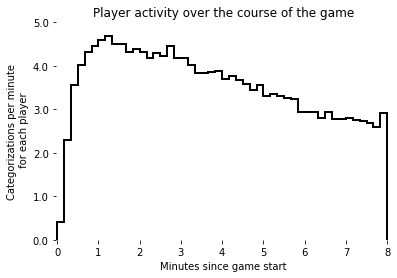

In [4]:
plt.hist(np.array(times)-60, # subtract exposition minute
         bins=np.arange(0,481,10), histtype='step', linewidth=2, color='k');
plt.yticks(np.arange(0,2001,400), np.arange(0,2001,400)/2400*6);
plt.xticks(np.arange(0,481,60), np.arange(0,9));
plt.xlabel('Minutes since game start')
plt.ylabel('Categorizations per minute\n for each player')
plt.xlim(-2,485)
plt.box(False)
plt.title("Player activity over the course of the game")
plt.savefig("../documents/images/player_activity.png", dpi=200)

In [5]:
# total number of player decisions
np.sum(drops)

68229

In [6]:
# number of classifications made, on average, per player
np.mean(drops)/2/20

28.42875

In [7]:
# number of adoptions made on average
df['adoptions'].mean()

16.15875

## compute statistics about players confidence

In [8]:
# compute players' discrimination beween elements of the mystery based on end-of-game survey
df['suspect_diff'] = df[['suspect_1', 'suspect_2', 'suspect_3']].max(axis=1).astype(float) - df[['suspect_1', 'suspect_2', 'suspect_3']].min(axis=1).astype(float)
df['appearance_diff'] = df[['appearance_1', 'appearance_2']].max(axis=1).astype(float) - df[['appearance_1', 'appearance_2']].min(axis=1).astype(float)
df['clothing_diff'] = df[['clothing_1', 'clothing_2']].max(axis=1).astype(float) - df[['clothing_1', 'clothing_2']].min(axis=1).astype(float)
df['tool_diff'] = df[['tool_1', 'tool_2']].max(axis=1).astype(float) - df[['tool_1', 'tool_2']].min(axis=1).astype(float)
df['vehicle_diff'] = df[['vehicle_1', 'vehicle_2']].max(axis=1).astype(float) - df[['vehicle_1', 'vehicle_2']].min(axis=1).astype(float)

df[['suspect_diff', 'appearance_diff', 'clothing_diff', 'tool_diff', 'vehicle_diff']].mean()

suspect_diff       48.186317
appearance_diff    30.101979
clothing_diff      31.604131
tool_diff          32.669105
vehicle_diff       40.978916
dtype: float64

In [9]:
# compute fraction of all players with at least one very confident answer
len(df[df['max_assessment']>=95])/2400

0.5020833333333333

## Compute demographic characteristics

In [10]:
df.fillna("", inplace=True)

# process gender information
def group_genders(s1):
    s = str(s1).lower().strip().replace(" ","").replace("-","")
        
    if (s in ["female", "f", "woman", "ciswoman"] or
        "fem" in s):
        return "f"
    elif (s in ["male", "m", "man", "mal", "mae", "malw", "mali", "msle", "make"]):  # some bad misspellings in this dataset. 
        return "m"
    elif ((s == "") or ("prefernot" in s)):
        return "n/a"
    elif (s in ["nonbinary", "n"]):
        return "nb"
    else:
        return s
    
df['gender2'] = df['gender'].apply(group_genders)
df['gender2'].value_counts()

m          1198
f          1078
n/a         106
nb            9
1             2
ftm           2
21            1
2             1
agender       1
42            1
gender        1
Name: gender2, dtype: int64

In [11]:
df['age'] = df['age'].apply(lambda s: int(s) if len(s)>0 else np.nan)
df['age'] = df['age'].apply(lambda s: s if 10<s<100 else np.nan)

In [12]:
df['age'].mean()

37.146214099216714

In [13]:
df['age'].median()

35.0

In [14]:
df['education'].value_counts()/2400

bachelor       0.487917
high-school    0.269583
master         0.161667
               0.047917
other          0.032917
Name: education, dtype: float64

## compute dropout characteristics

In [15]:
# fraction who completed all steps
df['completed'].mean()

0.9683333333333334

In [16]:
df['idled'].mean() 

0.27291666666666664

In [17]:
# difference in dropout percentage by condition
dropouts = [df[(df['treatment'] == 'c') & (df['caveman'])]['completed'].mean(),
            df[(df['treatment'] == 'c') & (~df['caveman'])]['completed'].mean(),
            df[(df['treatment'] == 't') & (df['caveman'])]['completed'].mean(),
            df[(df['treatment'] == 't') & (~df['caveman'])]['completed'].mean()]
(max(dropouts) - min(dropouts)) * 100

0.33333333333332993

## Print players' strategies

In [18]:
for i, s in df['strategy'].apply(lambda s: str(s).lower()).sort_values().items():
    if len(s)>0:
        print(s)
        print("")


tried to eliminate clues that seemed irrelevant to establishing who the criminal was.

100

15

2

2

3

3

76

? i didn't have one - i couldn't figure anything out. none of the info seemed contradictory, so i couldn't rule anything out. it says above that everything was true - which is a bit overwhelming. it didn't make sense, in the context of this being a game and not real life, that everything would be true. so i only picked a few things, as a random guess and just hoped.

a random guess? it felt like i could make a plausible case for any of the suspects. there were so many variables to consider that i honestly can't remember which one(s) steered me towards mills

a strategy game where you have partial information

absolutely could not give you an intelligent accounting. i just looked at what my other collaborators deemed important and if there were multiple hits, i added it.

addign clue togetther. i play dungeons and dragons so this is just like that 

after finding some convinc


i tried to find evidence that supported other evidence that i was seeing, and tried to disregard evidence that didn't seem to have as many supporting bits of evidence.

i tried to find evidence that was linked to other evidence.

i tried to find evidence that was supported by other evidence.

i tried to find information that multiple sources seemed to agree on.

i tried to find leads and determine myself which one i believed. cracking into new clues wasn't an easy process.

i tried to find links among the clues.

i tried to find matching clues and i looked for the which suspect had the most matching clues.

i tried to find matching pieces of evidence

i tried to find one clue that had the most likely lead and followed it from there. 

i tried to find plausible clues and tried to exclude the collaborators who i thought were giving poor information.

i tried to find relevant information that wasn't too general and seemed to be connected with the crime.

i tried to find similar clues but

no specific strategy used

no strategy

no strategy

no strategy

no strategy

no strategy - just went off of what made sense and what i read

no strategy i was used in this game

no strategy really, i kind of settled on certain aspects with no real reason and gathered clues pertaining to it.

no strategy was used

no strategy was used

no strategy was used

no strategy, i was confused the whole time

none

none

none

none

none

none

none. i couldn't play

none. it just felt completely random with nothing to really go off of and was very confusing to me. 

nonthin

normal

normal

not entirely sure- kind of a scramble at first 

not much

not sure

not sure, i just tried to find similarities in the clues and put them together like a storyboard i guess.

not sure?     just went with gut feelings

nothing

nothing

nothing

nothing

nothing

nothing

nothing

nothing 

nothing in the game looked false i only put one answer for false because it didnt seem right that every single thing 